# Model Loading

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import argparse
import logging
from datetime import datetime, timedelta, date
import torch
import torch.nn.functional as F
import sklearn.metrics as metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch_geometric.utils.convert import from_networkx

In [2]:
from networks_pyg.GCN import *
from datasets.Myloader import traffic_mtsc_loader
# from optim import Mytrainer
# from optim.loss import loss_function,init_center
# from datasets import dataloader_pyg as dataloader
# from datasets import Myloader
from networks_pyg.init import init_model
from optim.loss_my import anomaly_score

from sklearn.metrics import *

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
parser = argparse.ArgumentParser(description='OCGNN')
parser.add_argument("--dataset", type=str, default='cora',
        help="dataset")
parser.add_argument("--dropout", type=float, default=0.25,
        help="dropout probability")
parser.add_argument("--nu", type=float, default=0.01, # 0.2
        help="hyperparameter nu (must be 0 < nu <= 1)")
parser.add_argument("--gpu", type=int, default=0,
        help="gpu")
parser.add_argument("--seed", type=int, default=52,
        help="random seed, -1 means dont fix seed")
parser.add_argument("--module", type=str, default='GraphSAGE',
        help="GCN/GAT/GIN/GraphSAGE/GAE")
parser.add_argument('--n-worker', type=int,default=1,
        help='number of workers when dataloading')
parser.add_argument('--batch-size', type=int,default=128,
        help='batch size')
parser.add_argument("--lr", type=float, default=1e-3,
        help="learning rate")
parser.add_argument("--normal-class", type=int, default=0,
        help="normal class")
parser.add_argument("--n-epochs", type=int, default=100,
        help="number of training epochs")
parser.add_argument("--n-hidden", type=int, default=32,
        help="number of hidden gnn units")
parser.add_argument("--n-layers", type=int, default=2,
        help="number of hidden gnn layers")
parser.add_argument("--weight-decay", type=float, default=5e-4,
        help="Weight for L2 loss")
parser.add_argument('--early-stop', action='store_true', default=False,
                    help="indicates whether to use early stop or not")
parser.add_argument("--self-loop", action='store_true',
        help="graph self-loop (default=False)")
parser.add_argument("--norm", action='store_true',
        help="graph normalization (default=False)")
parser.add_argument("--reverse", default=False,
        help='Reverse of the adjacency matrix')
parser.add_argument("--exp-name", default='test',
        help='exp name to save model and log')
parser.set_defaults(self_loop=True)
parser.set_defaults(norm=False)
# args = parser.parse_args()
args = parser.parse_args(args=[])
# if args.module=='GCN':
#     #args.self_loop=True
#     args.norm=True
# if args.module=='GAE':
#     args.lr=0.002
#     args.dropout=0.
#     args.weight_decay=0.
#     # args.n_hidden=32
# #     args.self_loop=True
# # if args.module=='GraphSAGE':
# #     args.self_loop=True


In [5]:
# Data Loading
data_root_path = '/media/usr/HDD/Data/NAVER'
partition_list = os.listdir(data_root_path)
partition_list = [p for p in partition_list if p[0]=='2']
partition_list = np.sort(partition_list)

data_path = '/media/usr/HDD/Working/Naver_Data/data_parsing'



## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
print("# of filtered Events = ", len(accident_all))


# Profile Extraction Functions
def profile_extraction2(speed_all):
    # Day of Week => monday : 0, sunday : 6
    speed_all['weekday'] = [s.weekday() for s in speed_all.index]
    speed_all['timestamp'] = [s.time() for s in speed_all.index]
    
    profile_mean = speed_all.groupby(['weekday', 'timestamp']).mean()
    profile_std = speed_all.groupby(['weekday', 'timestamp']).std()
    
    speed_all = speed_all.drop(['weekday', 'timestamp'], axis=1)
    
    return speed_all, profile_mean, profile_std

# of filtered Events =  849


In [6]:
## https://github.com/mangushev/mtad-tf/blob/main/evaluate.py
#just like onmianomaly, no delta. If we hit anuthing in anomaly interval, whole anomaly segment is correctly identified
#-----------------------
#1|0|1|1|1|0|0|0|1|1|1|1  Labels
#-----------------------
#0|0|0|1|1|0|0|0|0|0|1|0  Predictions
#-----------------------
#0|0|1|1|1|0|0|0|1|1|1|1  Adjusted
#-----------------------
def adjust_predictions(predictions, labels):
  adjustment_started = False
  new_pred = predictions

  for i in range(len(predictions)):
    if labels[i] == 1:
      if predictions[i] == 1:
        if not adjustment_started:
          adjustment_started = True
          for j in range(i, 0, -1):
            if labels[j] == 1:
              new_pred[j] = 1
            else:
              break
    else:
      adjustment_started = False

    if adjustment_started:
      new_pred[i] = 1
      
  return new_pred

In [7]:
def evaluate(true, pred, score, adjust = False, plot=False, print_=False):
#     true = label_all
#     pred = list(map(int, [s>0 for s in score_all]))
    if adjust:
        pred = adjust_predictions(pred, true)
    CM = confusion_matrix(true, pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    acc = accuracy_score(true, pred)
    # auc = roc_auc_score(true, pred)
    auc = roc_auc_score(true, score)
#     far = FP / (FP+TN)
    far = FP / (TP+FP)
    pre = precision_score(true, pred, pos_label=1)
    rec = recall_score(true, pred, pos_label=1)
    macro_f1 = f1_score(true, pred, average='macro')
    weighted_f1 = f1_score(true, pred, average='weighted')
    ap = average_precision_score(true, score)
    # ap = average_precision_score(true, pred)
    if plot:
        plt.figure(figsize=(40, 5))
        plt.plot(true)
        plt.plot(pred)
    if print_:
        print('Accuracy \t{:.4f}'.format(acc))
        print('AUC score \t{:.4f}'.format(auc))
        print('FAR score \t{:.4f}'.format(far))
        print('Precision \t{:.4f}'.format(pre))
        print('Recall   \t{:.4f}'.format(rec))
        print('Macro F1 \t{:.4f}'.format(macro_f1))
        print('weighted F1 \t{:.4f}'.format(weighted_f1))
        print('Avg Precision \t{:.4f}'.format(ap))
        print(classification_report(true, pred))
    return [acc, auc, far, pre, rec, macro_f1, weighted_f1, ap]

# Dataset Loading

In [8]:
# target_sid = 1210005301 ## 1210005301  ## 1030001902
dataset = '1210005301_mtsc'

# train_df = pd.read_csv('../data/{}/train_x.csv'.format(dataset), index_col=0)
# val_df = pd.read_csv('../data/{}/val_x.csv'.format(dataset), index_col=0)
# test_df = pd.read_csv('../data/{}/test_x.csv'.format(dataset), index_col=0)
# train_df.columns = train_df.columns.astype(int)
# val_df.columns = val_df.columns.astype(int)
# test_df.columns = test_df.columns.astype(int)


# train_label = pd.read_csv('../data/{}/train_y.csv'.format(dataset), index_col=0)
# val_label = pd.read_csv('../data/{}/val_y.csv'.format(dataset), index_col=0)
# test_label = pd.read_csv('../data/{}/test_y.csv'.format(dataset), index_col=0)

# H = nx.read_gpickle("../data/{}/sensor_graph.gpickle".format(dataset))

# All Results

In [9]:
## load accident_all
accident_all = pd.read_csv('../data/accident_all.csv', index_col=0)
accident_all['created'] = pd.to_datetime(accident_all['created'])
print("# of filtered Events = ", len(accident_all))

# of filtered Events =  849


In [10]:
result_all = []
target_sid = 1210005301 ## 1210005301  ## 1030001902
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

args.gpu = 0

for normalize in ['standard']:
    # data
    args.dataset = '{}_mtsc'.format(target_sid)
    args.normalize = normalize
    args.bias = True
#     df_all_norm, label_df, H = preprocessing(eventID, normalize)
    train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
    print(len(train_loader), len(val_loader), len(test_loader))

    for nu in ['0.01', '0.05','0.10', '0.20', '0.30']:
        # for module in ['GCN_gc', 'GCN_traffic', 'GraphSAGE_gc']:
        # for name, module in zip(['GCN', 'GraphSAGE', 'STGCN',], ['GCN_gc','GraphSAGE_gc', 'STGCN']):
        for hidden_dim in [8, 16, 32, 64, 128]:
            args.n_hidden = hidden_dim
            name = 'STGCN'
            module = 'STGCN'

            args.module=module
            args.nu = float(nu)
            train_mode = 'all' # all. select
            args.self_loop = 'True'
            args.pooling = 'sum'

            args.exp_name = f'{args.dataset}_{name}_{args.pooling}_bias_{nu}_{args.n_hidden}'


            checkpoints_path=f'./checkpoints_sensitivity/{args.dataset}/{args.exp_name}+bestcheckpoint.pt'
            print("##############################")
            print(checkpoints_path)
            # print(args)

            # model
            input_dim = 12
            model = init_model(args, input_dim)
            model.to(device='cpu')
            model.load_state_dict(torch.load(checkpoints_path)['model'])
            model.to(device=f'cuda:{args.gpu}')
            model.eval()
            data_center = torch.load(checkpoints_path)['data_center'].to(device=f'cuda:{args.gpu}')
            radius = torch.load(checkpoints_path)['radius'].to(device=f'cuda:{args.gpu}')

            out_all, dist_all, score_all = [], [], []
            for ix, data in tqdm(enumerate(val_loader)):
                output = model(data.to(device=f'cuda:{args.gpu}'))
                out_all.append(output.cpu().detach().numpy())
                dist, _ = anomaly_score(data_center, output, radius)
                dist_all.append(dist.cpu().detach().numpy())
                # score_all.append(score.cpu().detach().numpy())
            dist_all = np.concatenate(dist_all)
            new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
            print(radius, new_radius)


            out_all, dist_all, score_all = [], [], []
            label_all = []
            for ix, data in tqdm(enumerate(test_loader)):
                output = model(data.to(device=f'cuda:{args.gpu}'))
                out_all.append(output.cpu().detach().numpy())
                label_all.append(data.y.cpu().detach().numpy())
                dist, score = anomaly_score(data_center, output, new_radius) # new_radius
                dist_all.append(dist.cpu().detach().numpy())
                score_all.append(score.cpu().detach().numpy())
            label_all = np.concatenate(label_all)
            score_all = np.concatenate(score_all)
            dist_all = np.concatenate(dist_all)

            pred = (score_all > 0).astype(int)

            acc, auc, far, pre, rec, macro_f1, weight_f1, ap = evaluate(label_all, pred, score_all, adjust=False, plot=False)
            result_all.append([name, args.normalize, args.nu, hidden_dim, False, acc, auc, far, pre, rec, macro_f1, weight_f1, ap])
            acc, auc, far, pre, rec, macro_f1, weight_f1, ap = evaluate(label_all, pred, score_all, adjust=True, plot=False)
            result_all.append([name, args.normalize, args.nu, hidden_dim, True, acc, auc, far, pre, rec, macro_f1, weight_f1, ap])

train dataset


  0%|          | 0/5296 [00:00<?, ?it/s]/home/jiin/anaconda3/envs/AID/lib/python3.10/site-packages/torch_geometric/utils/convert.py:249: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data[key] = torch.tensor(value)
100%|██████████| 5296/5296 [00:01<00:00, 3241.57it/s]


val dataset


100%|██████████| 1806/1806 [00:00<00:00, 3251.74it/s]


test dataset


100%|██████████| 1708/1708 [00:00<00:00, 3172.80it/s]


42 15 14
##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.01_8+bestcheckpoint.pt
Parameter number of STGCN Net is: 668


15it [00:01,  8.50it/s]


tensor(9.5168, device='cuda:0', dtype=torch.float64) 34.2057071685791


14it [00:00, 42.58it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.01_16+bestcheckpoint.pt
Parameter number of STGCN Net is: 932


15it [00:00, 49.58it/s]


tensor(29.7555, device='cuda:0', dtype=torch.float64) 39.089733123779304


14it [00:00, 47.40it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.01_32+bestcheckpoint.pt
Parameter number of STGCN Net is: 1460


15it [00:00, 39.93it/s]


tensor(11.4094, device='cuda:0', dtype=torch.float64) 31.815132236480714


14it [00:00, 42.24it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.01_64+bestcheckpoint.pt
Parameter number of STGCN Net is: 2516


15it [00:00, 43.62it/s]


tensor(39.0350, device='cuda:0', dtype=torch.float64) 59.50027961730958


14it [00:00, 28.77it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.01_128+bestcheckpoint.pt
Parameter number of STGCN Net is: 4628


15it [00:00, 43.36it/s]


tensor(25.1531, device='cuda:0', dtype=torch.float64) 65.95733833312988


14it [00:00, 61.18it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.05_8+bestcheckpoint.pt
Parameter number of STGCN Net is: 668


15it [00:00, 31.72it/s]


tensor(11.6379, device='cuda:0', dtype=torch.float64) 13.380348682403564


14it [00:00, 54.54it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.05_16+bestcheckpoint.pt
Parameter number of STGCN Net is: 932


15it [00:00, 53.48it/s]


tensor(7.4209, device='cuda:0', dtype=torch.float64) 11.04652714729309


14it [00:00, 59.64it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.05_32+bestcheckpoint.pt
Parameter number of STGCN Net is: 1460


15it [00:00, 35.70it/s]


tensor(4.2902, device='cuda:0', dtype=torch.float64) 7.232415676116943


14it [00:00, 45.32it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.05_64+bestcheckpoint.pt
Parameter number of STGCN Net is: 2516


15it [00:00, 62.61it/s]


tensor(27.7654, device='cuda:0', dtype=torch.float64) 32.745375633239746


14it [00:00, 38.22it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.05_128+bestcheckpoint.pt
Parameter number of STGCN Net is: 4628


15it [00:00, 39.92it/s]


tensor(7.6992, device='cuda:0', dtype=torch.float64) 13.963905811309814


14it [00:00, 71.76it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.10_8+bestcheckpoint.pt
Parameter number of STGCN Net is: 668


15it [00:00, 39.60it/s]


tensor(12.8552, device='cuda:0', dtype=torch.float64) 18.568382263183594


14it [00:00, 69.28it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.10_16+bestcheckpoint.pt
Parameter number of STGCN Net is: 932


15it [00:00, 58.55it/s]


tensor(0.6378, device='cuda:0', dtype=torch.float64) 4.084730863571167


14it [00:00, 35.07it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.10_32+bestcheckpoint.pt
Parameter number of STGCN Net is: 1460


15it [00:00, 45.50it/s]


tensor(18.1848, device='cuda:0', dtype=torch.float64) 18.608991622924805


14it [00:00, 60.48it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.10_64+bestcheckpoint.pt
Parameter number of STGCN Net is: 2516


15it [00:00, 41.06it/s]


tensor(9.4571, device='cuda:0', dtype=torch.float64) 10.312566757202148


14it [00:00, 63.84it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.10_128+bestcheckpoint.pt
Parameter number of STGCN Net is: 4628


15it [00:00, 38.05it/s]


tensor(25.6452, device='cuda:0', dtype=torch.float64) 28.983773231506348


14it [00:00, 64.37it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.20_8+bestcheckpoint.pt
Parameter number of STGCN Net is: 668


15it [00:00, 42.83it/s]


tensor(8.8116, device='cuda:0', dtype=torch.float64) 8.625598907470703


14it [00:00, 31.70it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.20_16+bestcheckpoint.pt
Parameter number of STGCN Net is: 932


15it [00:00, 33.74it/s]


tensor(17.6916, device='cuda:0', dtype=torch.float64) 18.271818161010742


14it [00:00, 34.57it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.20_32+bestcheckpoint.pt
Parameter number of STGCN Net is: 1460


15it [00:00, 49.68it/s]


tensor(11.5193, device='cuda:0', dtype=torch.float64) 11.746274948120117


14it [00:00, 52.34it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.20_64+bestcheckpoint.pt
Parameter number of STGCN Net is: 2516


15it [00:00, 32.01it/s]


tensor(16.8852, device='cuda:0', dtype=torch.float64) 17.27911376953125


14it [00:00, 63.52it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.20_128+bestcheckpoint.pt
Parameter number of STGCN Net is: 4628


15it [00:00, 46.78it/s]


tensor(12.3938, device='cuda:0', dtype=torch.float64) 33.277618408203125


14it [00:00, 50.20it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.30_8+bestcheckpoint.pt
Parameter number of STGCN Net is: 668


15it [00:00, 37.90it/s]


tensor(9.9578, device='cuda:0', dtype=torch.float64) 9.888535022735596


14it [00:00, 44.43it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.30_16+bestcheckpoint.pt
Parameter number of STGCN Net is: 932


15it [00:00, 39.72it/s]


tensor(1.7969, device='cuda:0', dtype=torch.float64) 1.9830913543701172


14it [00:00, 57.09it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.30_32+bestcheckpoint.pt
Parameter number of STGCN Net is: 1460


15it [00:00, 38.31it/s]


tensor(3.1351, device='cuda:0', dtype=torch.float64) 8.6683669090271


14it [00:00, 44.93it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.30_64+bestcheckpoint.pt
Parameter number of STGCN Net is: 2516


15it [00:00, 45.38it/s]


tensor(4.7467, device='cuda:0', dtype=torch.float64) 10.912472248077393


14it [00:00, 62.72it/s]


##############################
./checkpoints_sensitivity/1210005301_mtsc/1210005301_mtsc_STGCN_sum_bias_0.30_128+bestcheckpoint.pt
Parameter number of STGCN Net is: 4628


15it [00:00, 33.39it/s]


tensor(59.6522, device='cuda:0', dtype=torch.float64) 73.18301773071289


14it [00:00, 57.35it/s]


In [11]:
result_all = pd.DataFrame(result_all, columns=['model', 'normalize', 'nu', 'hidden_dim', 'adjust', 'acc', 'AUC', 'far', 'precision', 'recall', 'F1_macro', 'F1_weight', 'AP'])
result_all


,model,normalize,nu,hidden_dim,adjust,acc,AUC,far,precision,recall,F1_macro,F1_weight,AP
0,STGCN,standard,0.01,8,False,0.830796,0.995935,0.000000,1.000000,0.058632,0.508636,0.763476,0.982513
1,STGCN,standard,0.01,8,True,0.960773,0.995935,0.000000,1.000000,0.781759,0.927080,0.958828,0.982513
2,STGCN,standard,0.01,16,False,0.830796,0.987770,0.000000,1.000000,0.058632,0.508636,0.763476,0.955535
3,STGCN,standard,0.01,16,True,0.960773,0.987770,0.000000,1.000000,0.781759,0.927080,0.958828,0.955535
4,STGCN,standard,0.01,32,False,0.829040,0.994644,0.000000,1.000000,0.048860,0.499396,0.759591,0.977948
5,STGCN,standard,0.01,32,True,0.960773,0.994644,0.000000,1.000000,0.781759,0.927080,0.958828,0.977948
6,STGCN,standard,0.01,64,False,0.830211,0.992232,0.000000,1.000000,0.055375,0.505574,0.762187,0.969149
7,STGCN,standard,0.01,64,True,0.960773,0.992232,0.000000,1.000000,0.781759,0.927080,0.958828,0.969149
8,STGCN,standard,0.01,128,False,0.830796,0.989740,0.000000,1.000000,0.058632,0.508636,0.763476,0.961548
9,STGCN,standard,0.01,128,True,0.960773,0.989740,0.000000,1.000000,0.781759,0.927080,0.958828,0.961548


In [12]:
result_all[(result_all.adjust==False)]

,model,normalize,nu,hidden_dim,adjust,acc,AUC,far,precision,recall,F1_macro,F1_weight,AP
0,STGCN,standard,0.01,8,False,0.830796,0.995935,0.000000,1.000000,0.058632,0.508636,0.763476,0.982513
2,STGCN,standard,0.01,16,False,0.830796,0.987770,0.000000,1.000000,0.058632,0.508636,0.763476,0.955535
4,STGCN,standard,0.01,32,False,0.829040,0.994644,0.000000,1.000000,0.048860,0.499396,0.759591,0.977948
6,STGCN,standard,0.01,64,False,0.830211,0.992232,0.000000,1.000000,0.055375,0.505574,0.762187,0.969149
8,STGCN,standard,0.01,128,False,0.830796,0.989740,0.000000,1.000000,0.058632,0.508636,0.763476,0.961548
10,STGCN,standard,0.05,8,False,0.865925,0.992409,0.000000,1.000000,0.254072,0.664821,0.831116,0.969264
12,STGCN,standard,0.05,16,False,0.868852,0.996715,0.000000,1.000000,0.270358,0.675808,0.836044,0.985736
14,STGCN,standard,0.05,32,False,0.864754,0.991497,0.000000,1.000000,0.247557,0.660352,0.829119,0.966079
16,STGCN,standard,0.05,64,False,0.863583,0.976534,0.000000,1.000000,0.241042,0.655840,0.827107,0.919899
18,STGCN,standard,0.05,128,False,0.865925,0.991586,0.000000,1.000000,0.254072,0.664821,0.831116,0.967541


In [13]:
# result_all.to_csv('result/1210005301_mtsc_SAD_bias_sensitive.csv')

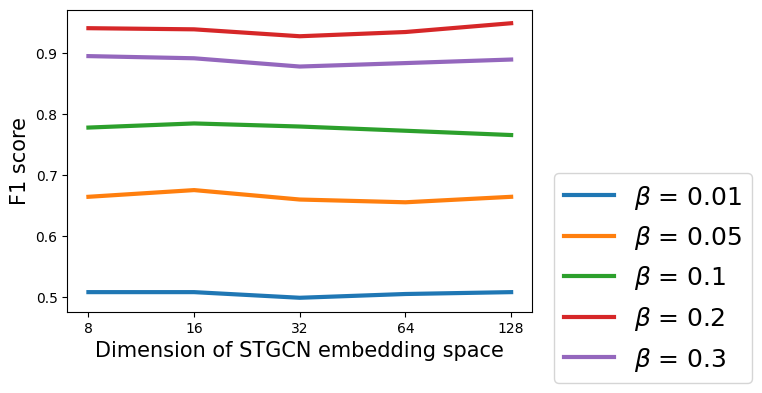

In [27]:
tmp = result_all[result_all.adjust==False]

for nu in [0.01, 0.05, 0.10, 0.20, 0.30]:
    plt.plot(np.arange(5), tmp[tmp.nu == nu]['F1_macro'], label=r'$ \beta$'+f' = {nu}', lw=3)
plt.xticks(ticks=np.arange(5), labels=['8','16','32','64','128'])
plt.ylabel('F1 score',fontsize=15)
plt.xlabel('Dimension of STGCN embedding space', fontsize=15)
# plt.title('Sensitive Analysis for Embedding Dimension',fontsize=15)
plt.legend(bbox_to_anchor=(1.5,0.5), loc='upper right', fontsize=18)
plt.rcParams['figure.dpi'] = 100
plt.savefig('../images/NRC_classification_sensitive_bias.pdf', dpi=250, bbox_inches = 'tight')
plt.show()


In [25]:
from PIL import Image

image1 = Image.open('../images/NRC_classification_sensitive_bias.png')
im1 = image1.convert('RGB')
im1.save('../images/NRC_classification_sensitive_bias.pdf')

# Case Result

In [137]:
args.dataset = '1210005301_mtsc'
# args.module = 'GraphSAGE_gc'
# args.module = 'GCN_gc'
args.module = 'STGCN'
name = 'STGCN'
args.normalize = 'standard'
args.nu = 0.2
args.pooling = 'sum'
args.reverse = False
# train_mode = 'all'
args.self_loop = 'True'
args.bias = False

args.exp_name = f'{args.dataset}_{name}_{args.pooling}_{args.nu}_{args.self_loop}'
# args.exp_name = 'test'


In [138]:
checkpoints_path=f'./checkpoints_SAD/{args.exp_name}+bestcheckpoint.pt'
checkpoints_path

'./checkpoints_SAD/1210005301_mtsc_STGCN_sum_0.2_True+bestcheckpoint.pt'

In [139]:
args.normalize

'standard'

In [140]:
target_sid = 1210005301 ## 1210005301 ## 1030001902
accident_case = accident_all[accident_all.loc[:, 'accident_sid'] == target_sid]
eventID = accident_case.eventId.iloc[0]

In [141]:
train_loader, val_loader, test_loader = traffic_mtsc_loader(args)
print(len(train_loader), len(val_loader), len(test_loader))

train dataset


100%|██████████| 5296/5296 [00:01<00:00, 4672.61it/s]


val dataset


100%|██████████| 1806/1806 [00:00<00:00, 4782.97it/s]


test dataset


100%|██████████| 1708/1708 [00:00<00:00, 4753.06it/s]

42 15 14


In [142]:
input_dim = 12
model = init_model(args, input_dim)
# model_1 = init_model(args, input_dim)
# model_50 = init_model(args, input_dim)
# model_100 = init_model(args, input_dim)

Parameter number of STGCN Net is: 1422


In [143]:
print(checkpoints_path)
model.load_state_dict(torch.load(checkpoints_path, map_location='cuda:0')['model'])
model.to(device=f'cuda:{args.gpu}')
model.eval()
data_center = torch.load(checkpoints_path, map_location='cuda')['data_center']
radius = torch.load(checkpoints_path, map_location='cuda')['radius']
model, data_center, radius

./checkpoints_SAD/1210005301_mtsc_STGCN_sum_0.2_True+bestcheckpoint.pt


(STGCN(
   (stblocks): ModuleList(
     (0): STblock(
       (tmp_conv1): TemporalConvLayer(
         (align): Align(
           (align_conv): Conv2d(1, 1, kernel_size=(1, 1), stride=(1, 1))
         )
         (causal_conv): CausalConv2d(1, 2, kernel_size=(3, 1), stride=(1, 1))
         (sigmoid): Sigmoid()
         (tanh): Tanh()
         (relu): ReLU()
         (leaky_relu): LeakyReLU(negative_slope=0.01)
         (silu): SiLU()
       )
       (graph_conv): GCNConv(1, 2)
       (tmp_conv2): TemporalConvLayer(
         (align): Align(
           (align_conv): Conv2d(2, 4, kernel_size=(1, 1), stride=(1, 1))
         )
         (causal_conv): CausalConv2d(2, 8, kernel_size=(3, 1), stride=(1, 1))
         (sigmoid): Sigmoid()
         (tanh): Tanh()
         (relu): ReLU()
         (leaky_relu): LeakyReLU(negative_slope=0.01)
         (silu): SiLU()
       )
       (relu): ReLU()
       (dropout): Dropout(p=0.25, inplace=False)
     )
     (1): STblock(
       (tmp_conv1): TemporalConv

In [144]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(val_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    if ix < 5:
        print(output[1][:2])
    # dist, score = anomaly_score(data_center, output, radius)
    dist = torch.sum((output - data_center) ** 2, dim=1)
    dist_all.append(dist.cpu().detach().numpy())
    # score_all.append(score.cpu().detach().numpy())
# label_all = np.concatenate(label_all)
# score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)
print(dist_all[:5])
# new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius = np.quantile(np.sqrt(dist_all), 1 - args.nu)
new_radius

15it [00:00, 76.59it/s]

tensor([0.4532, 1.1552], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.5917, 1.2243], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.4440, 1.1488], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.3879, 1.1030], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([0.5688, 1.1835], device='cuda:0', grad_fn=<SliceBackward0>)
[150.74303 152.31528 154.29828 156.76158 159.38097]


12.52044677734375

In [145]:
out_all, dist_all, score_all = [], [], []
label_all = []
for ix, data in tqdm(enumerate(test_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_all.append(output.cpu().detach().numpy())
    label_all.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, new_radius)
    dist_all.append(dist.cpu().detach().numpy())
    score_all.append(score.cpu().detach().numpy())
label_all = np.concatenate(label_all)
score_all = np.concatenate(score_all)
dist_all = np.concatenate(dist_all)

14it [00:00, 77.35it/s]


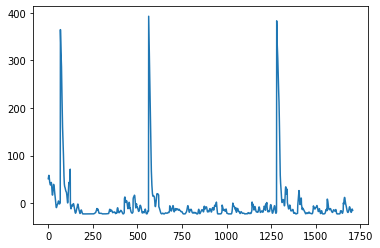

In [146]:
plt.plot(score_all)

Accuracy 	0.9590
AUC score 	0.9877
FAR score 	0.0813
Precision 	0.9187
Recall   	0.8469
Macro F1 	0.9283
weighted F1 	0.9584
Avg Precision 	0.9556
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1401
           1       0.92      0.85      0.88       307

    accuracy                           0.96      1708
   macro avg       0.94      0.92      0.93      1708
weighted avg       0.96      0.96      0.96      1708



[0.9590163934426229,
 0.9877379349789703,
 0.0812720848056537,
 0.9187279151943463,
 0.8469055374592834,
 0.9282929696402653,
 0.958356856616812,
 0.9555955333313867]

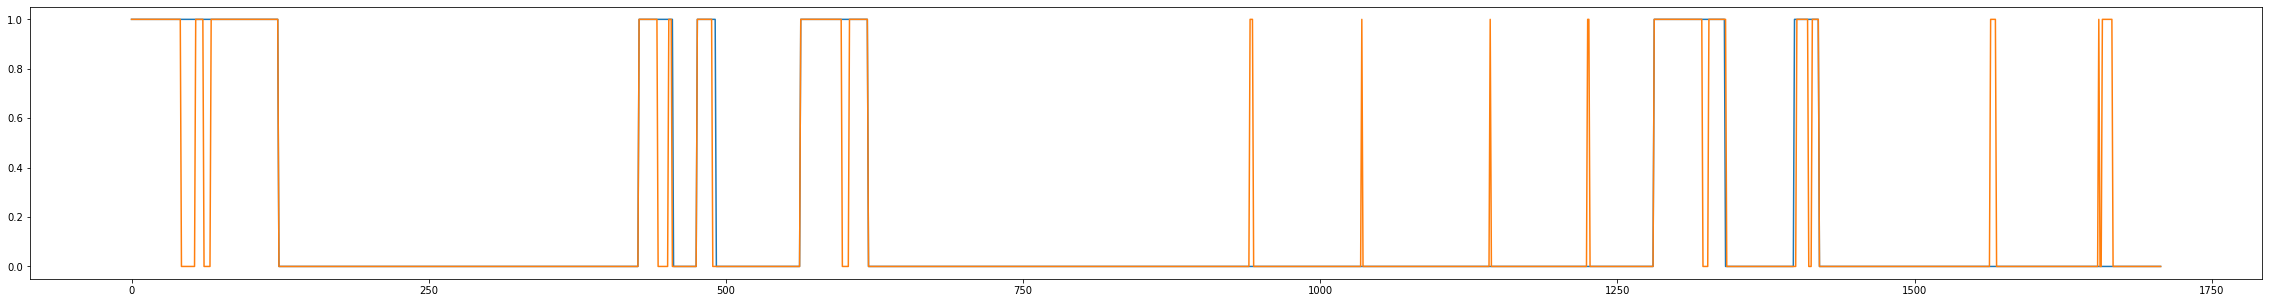

In [148]:
evaluate(label_all, score_all, adjust=False, plot=True, print_=True)

In [149]:
cm = confusion_matrix(label_all, (score_all > 0).astype(int))
cm

array([[1378,   23],
       [  47,  260]])

In [151]:
# evaluate(label_all, score_all, adjust=True, plot=True, print_=True)

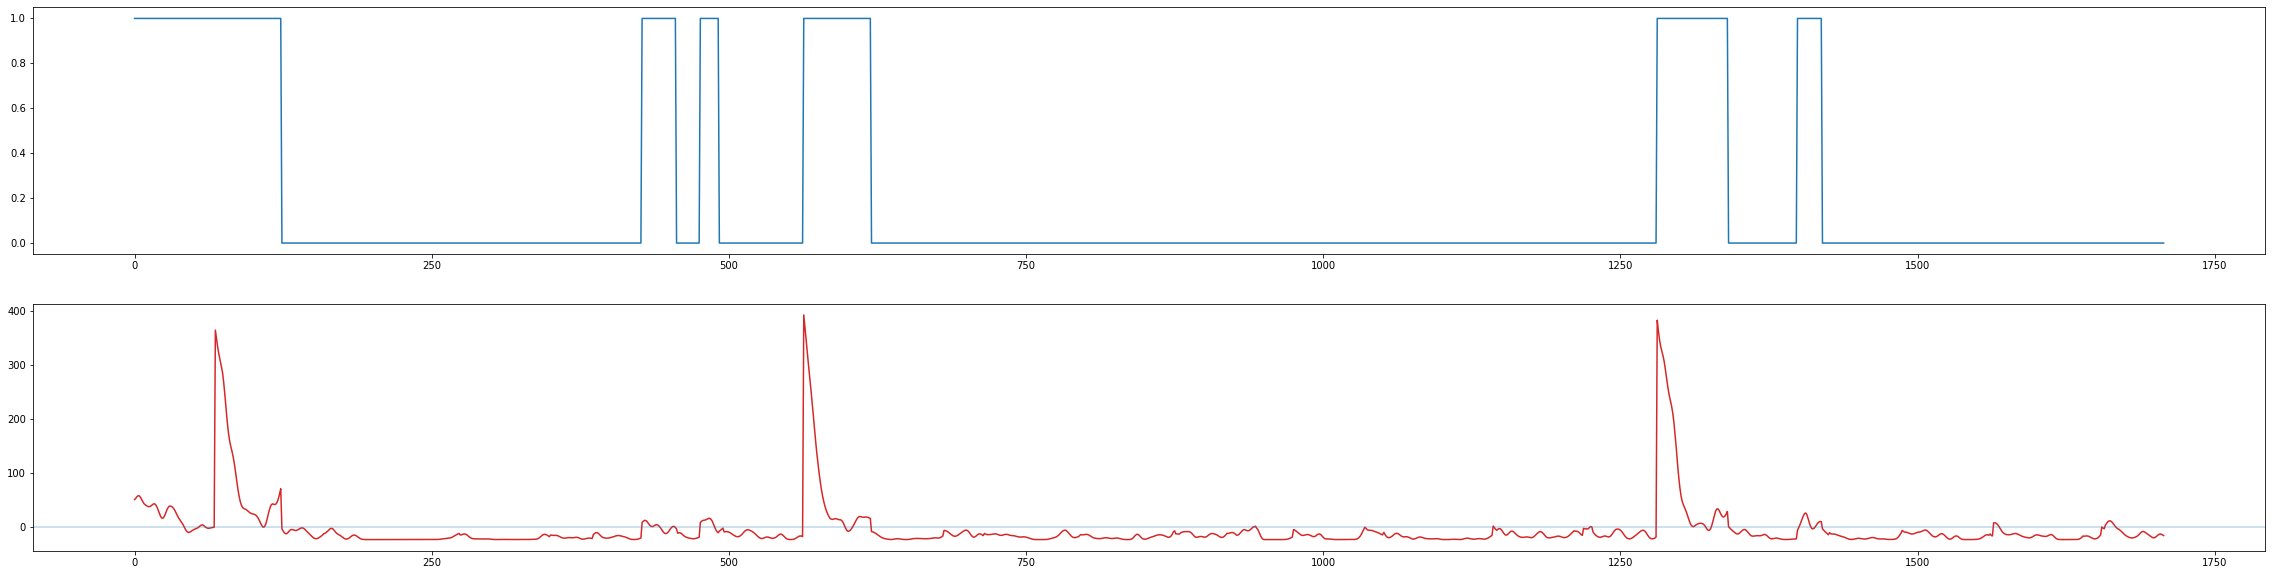

In [152]:
true = label_all
pred = list(map(int, [s>0 for s in score_all]))
plt.figure(figsize=(40, 10))
plt.subplot(2, 1, 1)
plt.plot(true[:4000])
plt.subplot(2, 1, 2)
plt.plot(score_all[:4000], color='tab:red')
# plt.ylim(-0.005, 0.01)
plt.axhline(0, alpha=0.3)


In [105]:
from optim.DeepSAD_trainer import graph_anomaly_evaluate

In [119]:
print(args)
print(checkpoints_path)
auc,ap,f1,acc,precision,recall,loss = graph_anomaly_evaluate(args,checkpoints_path,model, data_center, test_loader, radius, mode='test')

Namespace(dataset='1210005301_mtsc', dropout=0.25, nu=0.05, gpu=0, seed=52, module='GCN_gc', n_worker=1, batch_size=128, lr=0.001, normal_class=0, n_epochs=100, n_hidden=32, n_layers=2, weight_decay=0.0005, early_stop=False, self_loop='True', norm=False, reverse=False, exp_name='1210005301_mtsc_GCN_sum_0.05_True', normalize='standard', pooling='sum', bias=False)
./checkpoints_SAD/1210005301_mtsc_GCN_sum_0.05_True+bestcheckpoint.pt
model loaded.


In [120]:
auc,ap,f1,acc,precision,recall,loss

(0.9029218310792431,
 0.7428549328679408,
 0.6505295007564297,
 0.8647540983606558,
 0.6073446327683616,
 0.7003257328990228,
 1029587.47400199)

## Case prediction plot

In [53]:
detected = np.where(score_all > 0)[0]
# tmp = np.argsort(detected)[::-1]
tmp = np.random.choice(detected, 10)
tmp

array([1214,  168, 8452, 4446, 1522, 4958, 1593, 5653, 1501, 1566])

In [54]:
with open(os.path.join(data_extraction_path, str(eventID)), 'rb') as f:
        test = pickle.load(f)

path_inflow = test['path_inflow']
path_outflow = test['path_outflow']

# test_df = df_all_norm[(df_all_norm.index >= datetime(2021, 1, 1)) & (df_all_norm.index < datetime(2021, 2, 1))]
# test_df = test_df.rolling(window=3).mean()

In [55]:
test_df.index = pd.to_datetime(test_df.index)

In [56]:
df_agg_inflow, df_agg_outflow = [], []
for hop in [0, 1, 2, 3]:
    inflow = np.unique([p[hop] for p in path_inflow])
    outflow = np.unique([p[hop] for p in path_outflow])
    inflow = [p for p in inflow if p in list(test_df.columns)]
    outflow = [p for p in outflow if p in list(test_df.columns)]
    df_agg_inflow.append(test_df[inflow].mean(axis=1))
    df_agg_outflow.append(test_df[outflow].mean(axis=1))
df_agg_inflow = pd.concat(df_agg_inflow, axis=1)
df_agg_outflow = pd.concat(df_agg_outflow, axis=1)

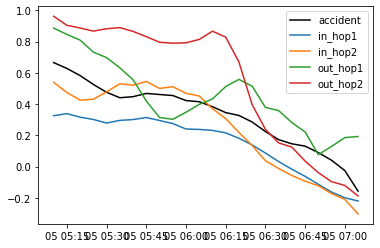

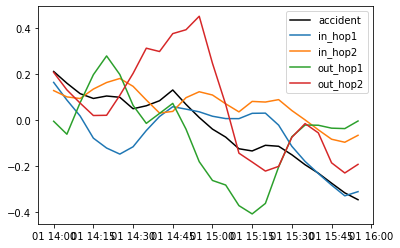

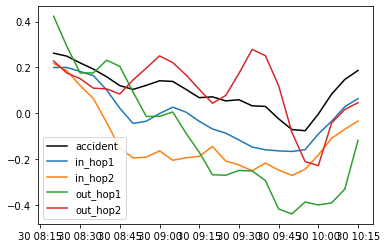

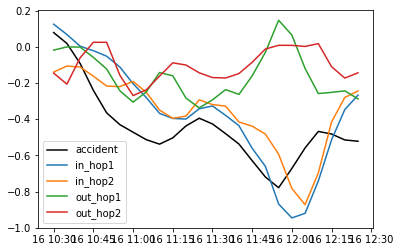

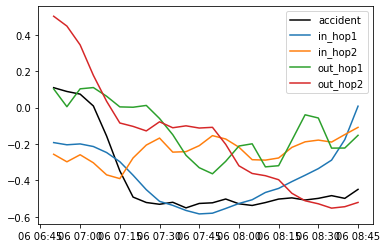

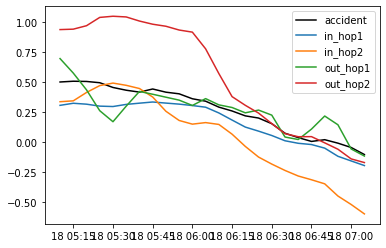

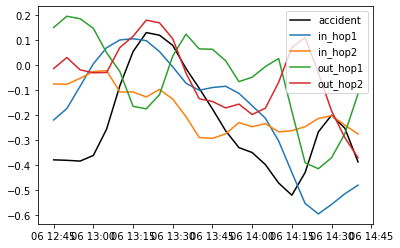

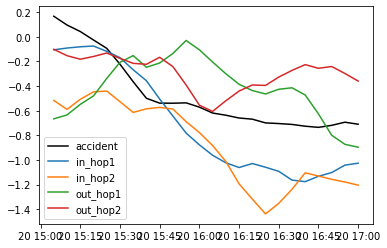

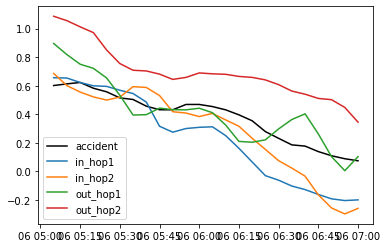

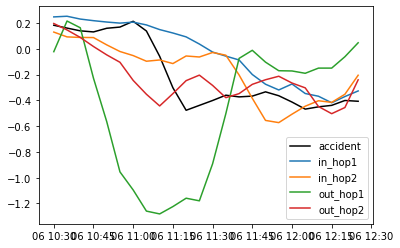

In [57]:
for i in tmp:
    plt.figure()
    plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
    plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
    plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
    plt.plot(df_agg_outflow[i:i+24][1], label='out_hop1')
    plt.plot(df_agg_outflow[i:i+24][2], label='out_hop2')
    plt.legend()
    plt.show()
    

### Prediction Case for true incident

Detected
MTTD =  [6]


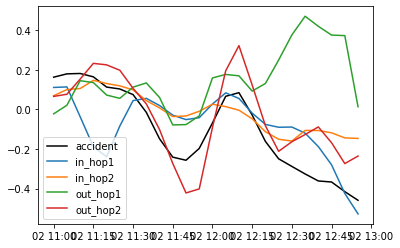

Detected
MTTD =  [9]


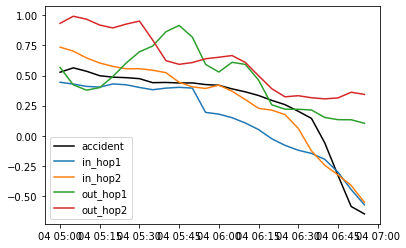

Detected
MTTD =  [26]


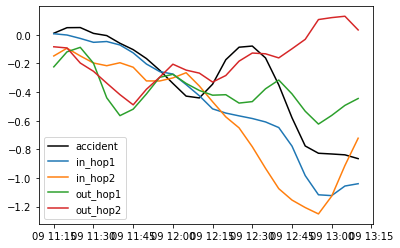

Not detected
Detected
MTTD =  [8]


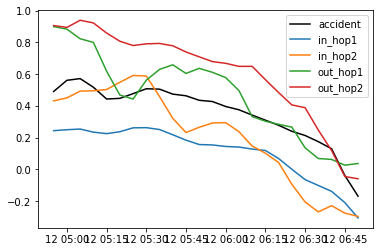

Detected
MTTD =  [5]


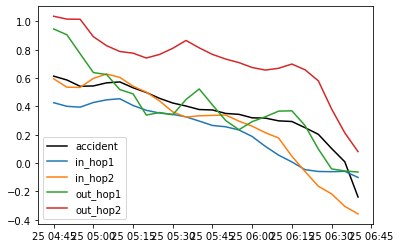

Detected
MTTD =  [14]


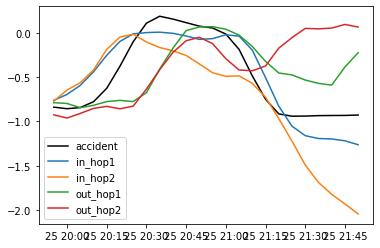

In [58]:
st_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == 1)[0]
ed_time_list = np.where(np.diff(label_all.reshape(-1), prepend=1) == -1)[0][1:]

pred = list(map(int, [s>0 for s in score_all]))

for st, ed in zip(st_time_list, ed_time_list):
    if sum(pred[st:ed]) == 0:
        print('Not detected')
    else:
        print('Detected')
        print('MTTD = ', np.where(np.diff(pred[st:ed], prepend=1)==1)[0])

        i = st + np.where(np.diff(pred[st:ed], prepend=1)==1)[0][0]
        plt.figure()
        plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
        plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
        plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
        plt.plot(df_agg_outflow[i:i+24][1], label='out_hop1')
        plt.plot(df_agg_outflow[i:i+24][2], label='out_hop2')
        plt.legend()
        plt.show()
    

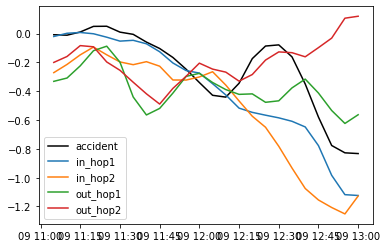

2437 0


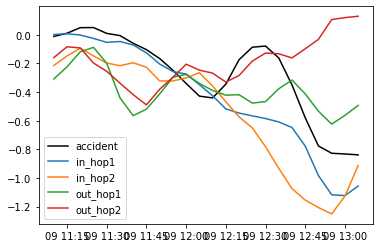

2438 0


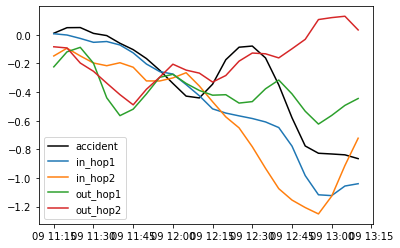

2439 0


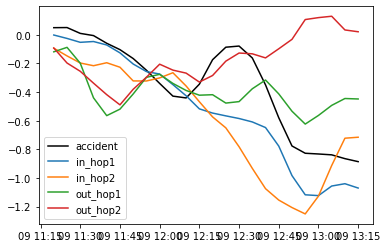

2440 0


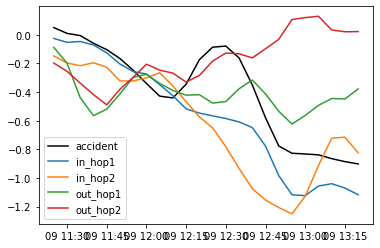

2441 0


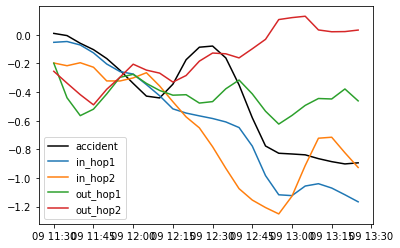

2442 0


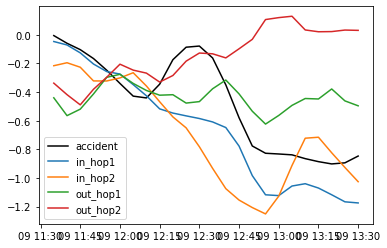

2443 0


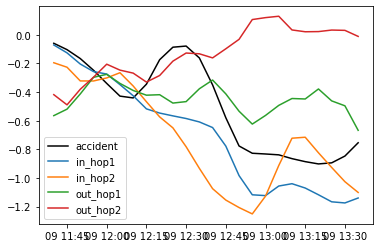

2444 0


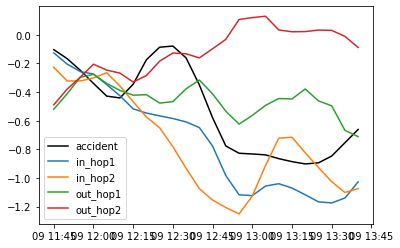

2445 0


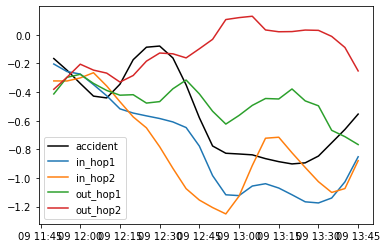

2446 0


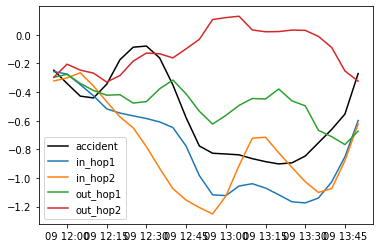

2447 0


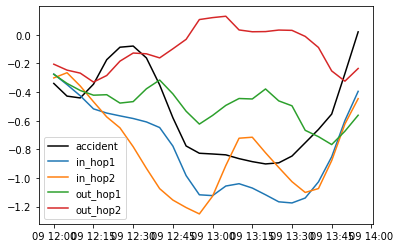

2448 0


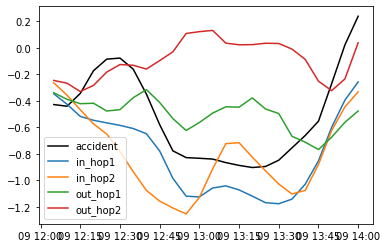

2449 0


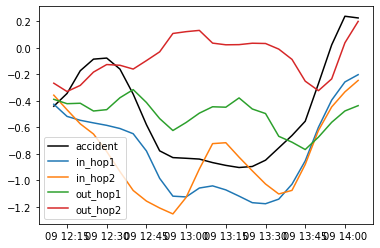

2450 0


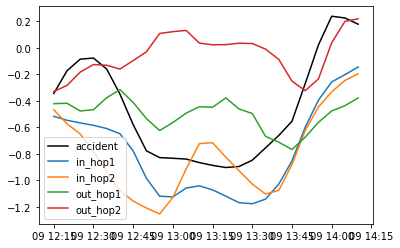

2451 0


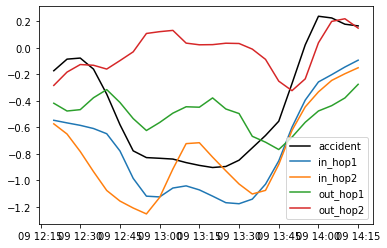

2452 0


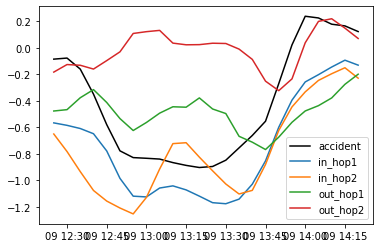

2453 0


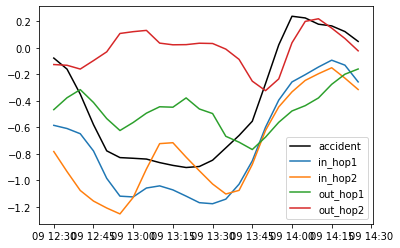

2454 0


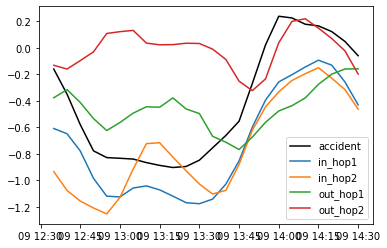

2455 0


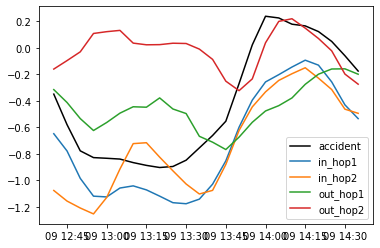

2456 0


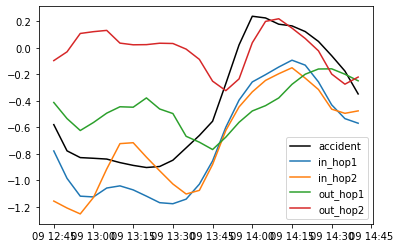

2457 0


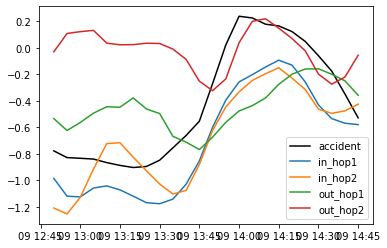

2458 0


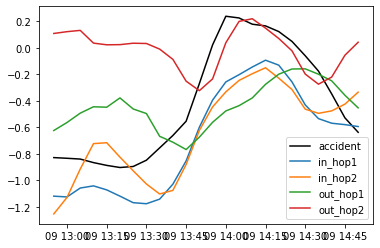

2459 0


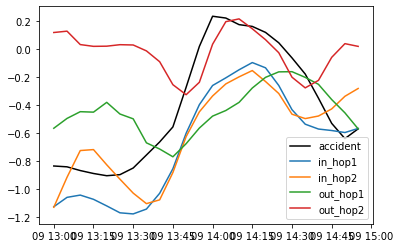

2460 0


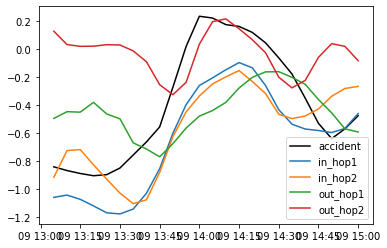

2461 0


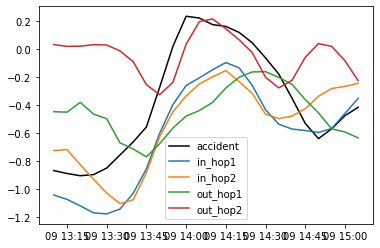

2462 0


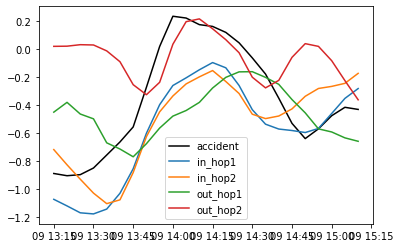

2463 0


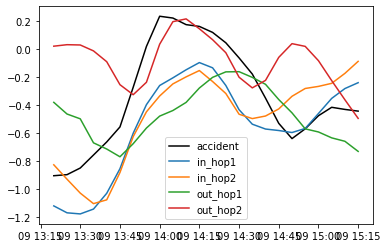

2464 0


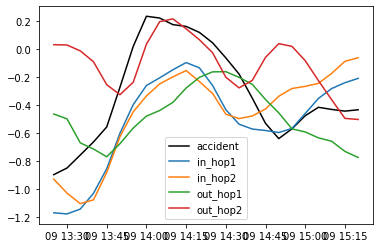

2465 0


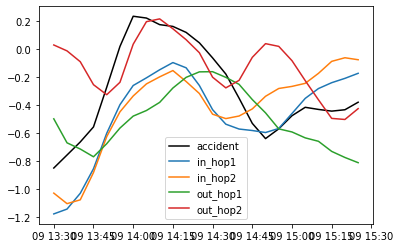

2466 0


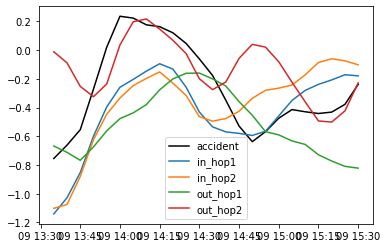

2467 0


In [76]:
cnt = 0
for i in range(1100, len(train_df)):
    
    if test_label.iloc[i, 0] == 0:
        continue
    else:
        plt.figure()
        plt.plot(df_agg_inflow[i:i+24][0], label='accident', color='k')
        plt.plot(df_agg_inflow[i:i+24][1], label='in_hop1')
        plt.plot(df_agg_inflow[i:i+24][2], label='in_hop2')
        plt.plot(df_agg_outflow[i:i+24][1], label='out_hop1')
        plt.plot(df_agg_outflow[i:i+24][2], label='out_hop2')
        plt.legend()
        plt.show()
        print(i, pred[i])
        cnt += 1
    if cnt > 30 :
        break
    

## embedding distribution plot

### Test set

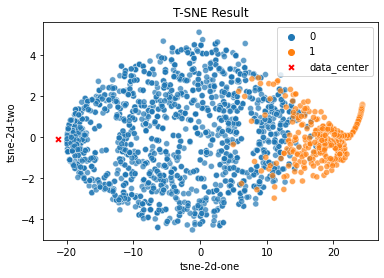

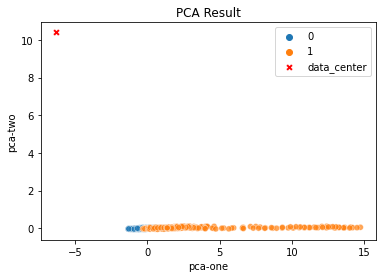

In [153]:
## test set all T-SNE
import seaborn as sns 


normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

rndperm = np.random.choice(normal, 2000)

## add data center
center_arr = data_center.detach().cpu().numpy()
out_center_all = np.concatenate([np.concatenate(out_all), center_arr.reshape(1, -1)])

## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=200)
tsne_all = tsne.fit_transform(out_center_all)

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = np.append(label_all, [-1])

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 2),
    data=tsne_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)

plt.title('T-SNE Result')
plt.show()


## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(out_center_all)

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = np.append(label_all, [-1])

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 2),
    data=pca_df.loc[np.append(rndperm, abnormal), :],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=pca_df[pca_df.y == -1]['pca-one'], y=pca_df[pca_df.y == -1]["pca-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)


plt.title('PCA Result')
plt.show()

Text(0, 0.5, 'Distance')

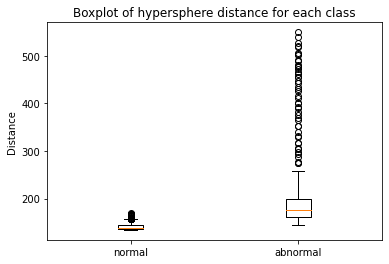

In [154]:
normal = np.where(label_all == 0)[0]
abnormal = np.where(label_all == 1)[0]

plt.boxplot([dist_all[normal], dist_all[abnormal]])
# plt.ylim(0, 1e3)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class')
plt.ylabel('Distance')

/tmp/ipykernel_428931/2113342768.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))


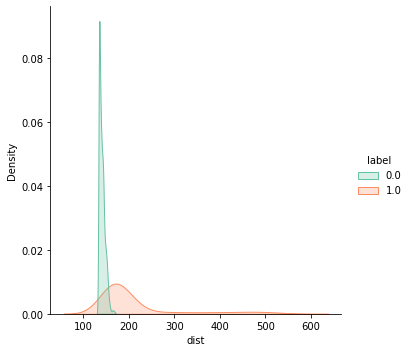

In [155]:
dist_df = pd.DataFrame([dist_all, label_all.reshape(-1)], index=['dist', 'label']).T
sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))

### Test set Recur vs Non-recur

In [111]:
test_df.index = pd.to_datetime(test_df.index)

In [112]:
test_df.index

DatetimeIndex(['2021-01-01 00:00:00', '2021-01-01 00:05:00',
               '2021-01-01 00:10:00', '2021-01-01 00:15:00',
               '2021-01-01 00:20:00', '2021-01-01 00:25:00',
               '2021-01-01 00:30:00', '2021-01-01 00:35:00',
               '2021-01-01 00:40:00', '2021-01-01 00:45:00',
               ...
               '2021-01-31 23:10:00', '2021-01-31 23:15:00',
               '2021-01-31 23:20:00', '2021-01-31 23:25:00',
               '2021-01-31 23:30:00', '2021-01-31 23:35:00',
               '2021-01-31 23:40:00', '2021-01-31 23:45:00',
               '2021-01-31 23:50:00', '2021-01-31 23:55:00'],
              dtype='datetime64[ns]', name='datetime', length=8928, freq=None)

In [113]:
recurrent_label = np.zeros(test_label.shape)
t0 = 76
t1 = 105
for i in range(len(test_label) // 288):
    if i == 0:   ## new year's day
        continue
    date = test_df.index[t0+288*i]
    # if datetime.strptime(date, '%Y-%m-%d %H:%M:%S').weekday() <= 4:
    if date.weekday() <= 4:
        recurrent_label[t0+288*i:t1+288*i] = 1
recurrent_label = recurrent_label[24:]

In [114]:
recurrent_label.shape, label_all.shape

((8904, 1), (8904, 1))

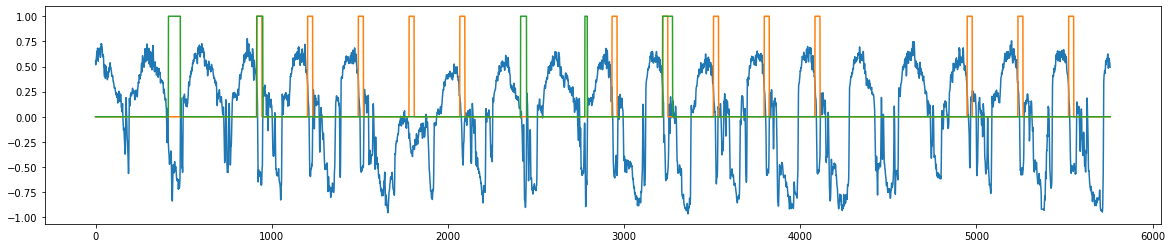

In [115]:
plt.figure(figsize=(20, 4))
plt.plot(test_df.iloc[24:288*20+24][target_sid].values)
# for i in range(15):
#     plt.axvspan(t0+288*i, t1+288*i, color='r', alpha=0.3)
plt.plot(recurrent_label[:288*20])
plt.plot(label_all[:288*20])

/tmp/ipykernel_2923519/1642118131.py:28: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


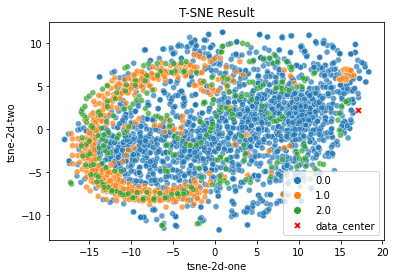

In [116]:
import seaborn as sns 

recurrent = np.where(recurrent_label == 1)[0]
nonrecurrent = np.where(label_all == 1)[0]

new_label = np.zeros(len(label_all))
new_label[recurrent] = 1
new_label[nonrecurrent] = 2

rndperm = np.random.choice(np.where(new_label == 0)[0], 2000)
recurrent = np.where(new_label == 1)[0]
nonrecurrent = np.where(new_label == 2)[0]

## add data center
center_arr = data_center.detach().cpu().numpy()
out_center_all = np.concatenate([np.concatenate(out_all)[np.concatenate([rndperm, recurrent, nonrecurrent])], center_arr.reshape(1, -1)])


## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=200)
tsne_all = tsne.fit_transform(out_center_all)

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = np.append(new_label[np.concatenate([rndperm, recurrent, nonrecurrent])], [-1])

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=tsne_df.iloc[:-1, :],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)

plt.title('T-SNE Result')
plt.show()


Text(0, 0.5, 'Distance')

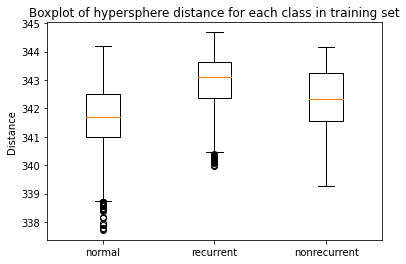

In [117]:
plt.boxplot([dist_all[np.where(new_label==0)[0]], dist_all[recurrent], dist_all[nonrecurrent]])
# plt.ylim(0, 800)
plt.xticks([1, 2, 3],['normal', 'recurrent', 'nonrecurrent'])
plt.title('Boxplot of hypersphere distance for each class in training set')
plt.ylabel('Distance')

/tmp/ipykernel_2923519/3855114425.py:2: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))


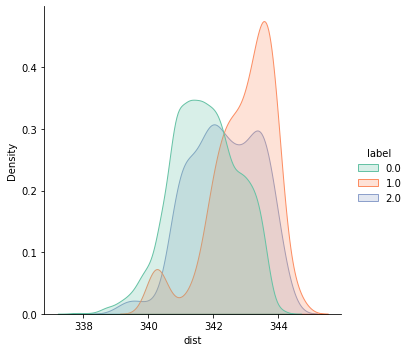

In [118]:
dist_df = pd.DataFrame([dist_all, new_label], index=['dist', 'label']).T
sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))

### Train set

In [71]:
out_train, dist_train, score_train = [], [], []
label_train = []
for ix, data in tqdm(enumerate(train_loader)):
    output = model(data.to(device=f'cuda:{args.gpu}'))
    out_train.append(output.cpu().detach().numpy())
    label_train.append(data.y.cpu().detach().numpy())
    dist, score = anomaly_score(data_center, output, radius)
    dist_train.append(dist.cpu().detach().numpy())
    score_train.append(score.cpu().detach().numpy())
label_train = np.concatenate(label_train)
score_train = np.concatenate(score_train)
dist_train = np.concatenate(dist_train)
out_train = np.concatenate(out_train)

405it [00:02, 196.93it/s]


/tmp/ipykernel_2923519/2179087459.py:20: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


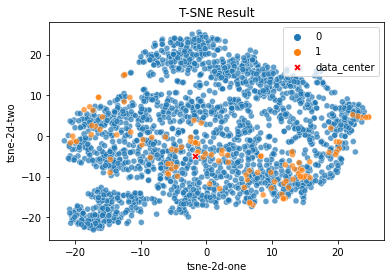

/tmp/ipykernel_2923519/2179087459.py:47: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


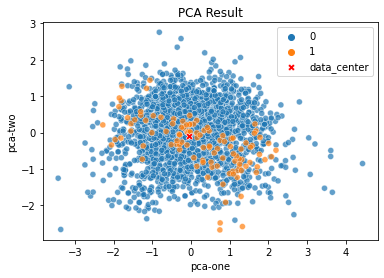

In [72]:
import seaborn as sns 

normal = np.where(label_train == 0)[0]
abnormal = np.where(label_train == 1)[0]
rndperm = np.random.choice(normal, 2000)

## add data center
center_arr = data_center.detach().cpu().numpy()
out_center_all = np.concatenate([out_train[np.concatenate([rndperm, abnormal])], center_arr.reshape(1,-1)])

## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100)
tsne_all = tsne.fit_transform(out_center_all)

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = np.append(label_train[np.concatenate([rndperm, abnormal])], [-1])

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=tsne_df.iloc[:-1],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)

plt.title('T-SNE Result')
plt.show()

## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_all = pca.fit_transform(out_center_all)

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = np.append(label_train[np.concatenate([rndperm, abnormal])], [-1])

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=pca_df.iloc[:-1],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=pca_df[pca_df.y == -1]["pca-one"], y=pca_df[pca_df.y == -1]["pca-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)

plt.title('PCA Result')
plt.show()


Text(0, 0.5, 'Distance')

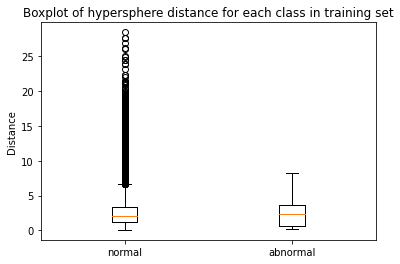

In [73]:
normal = np.where(label_train == 0)[0]
abnormal = np.where(label_train == 1)[0]

plt.boxplot([dist_train[normal], dist_train[abnormal]])
# plt.ylim(0, 1)
plt.xticks([1, 2],['normal', 'abnormal'])
plt.title('Boxplot of hypersphere distance for each class in training set')
plt.ylabel('Distance')

/tmp/ipykernel_2923519/2113342768.py:2: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))


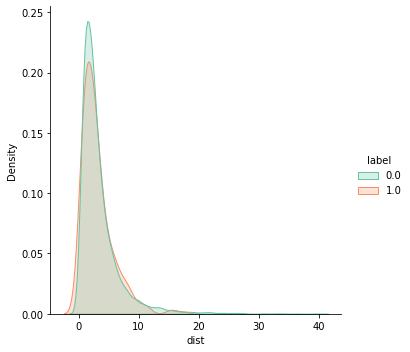

In [74]:
dist_df = pd.DataFrame([dist_all, label_all.reshape(-1)], index=['dist', 'label']).T
sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))

### Train set Recur vs Non-recur

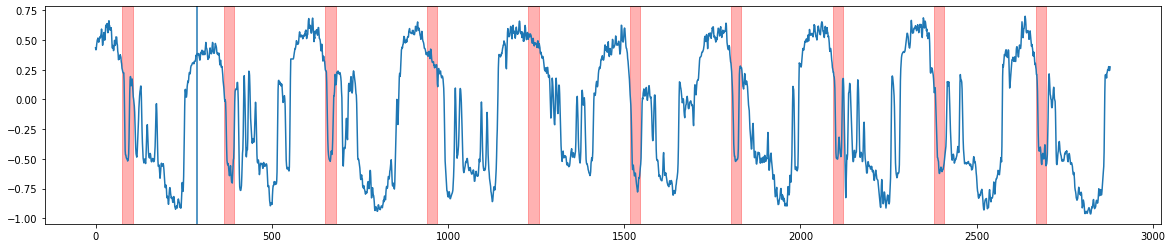

In [103]:
plt.figure(figsize=(20, 4))
plt.plot(train_df.iloc[:288*10][target_sid].values)
plt.axvline(288)
t0 = 76
t1 = 105
for i in range(10):
    plt.axvspan(t0+288*i, t1+288*i, color='r', alpha=0.3)


In [104]:
train_label.shape, train_df.shape, label_train.shape, out_train.shape

((25918, 1), (25918, 25), (25894, 1), (25894, 128))

In [105]:
recurrent_label = np.zeros(train_label.shape)
t0 = 76
t1 = 105
for i in range(len(train_label) // 288):
    date = train_df.index[t0+288*i]
    if datetime.strptime(date, '%Y-%m-%d %H:%M:%S').weekday() <= 4:
        recurrent_label[t0+288*i:t1+288*i] = 1
recurrent_label = recurrent_label[24:]

In [106]:
recurrent_label.shape, label_train.shape, out_train.shape

((25894, 1), (25894, 1), (25894, 128))

/tmp/ipykernel_725647/1284937174.py:29: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


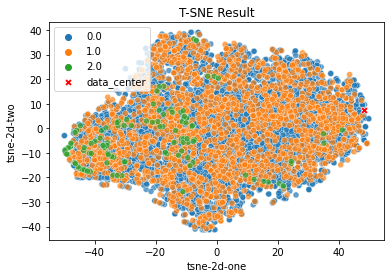

/tmp/ipykernel_725647/1284937174.py:56: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.scatterplot(


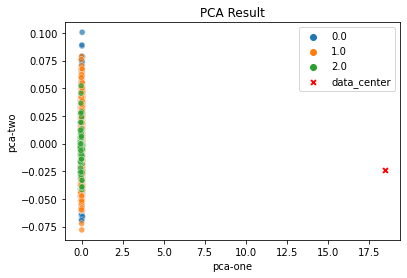

In [113]:
import seaborn as sns 

# normal = np.where(label_train == 0)[0]
# rndperm = np.random.choice(normal, 2000)

recurrent = np.where(recurrent_label == 1)[0]
nonrecurrent = np.where(label_train == 1)[0]

new_label = np.zeros(len(label_train))
new_label[recurrent] = 1
new_label[nonrecurrent] = 2

rndperm = np.random.choice(np.where(new_label==0)[0], 5000)
recurrent = np.where(new_label == 1)[0]
nonrecurrent = np.where(new_label == 2)[0]

out_center_all = np.concatenate([out_train[np.concatenate([rndperm, recurrent, nonrecurrent])], center_arr.reshape(1,-1)])


## tSNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=100)
tsne_all = tsne.fit_transform(out_center_all)

tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
tsne_df['y'] = np.append(new_label[np.concatenate([rndperm, recurrent, nonrecurrent])], [-1])

sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=tsne_df.iloc[:-1],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=tsne_df[tsne_df.y == -1]["tsne-2d-one"], y=tsne_df[tsne_df.y == -1]["tsne-2d-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)

plt.title('T-SNE Result')
plt.show()

## PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver='randomized')
pca_all = pca.fit_transform(out_center_all)

pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
pca_df['y'] = np.append(new_label[np.concatenate([rndperm, recurrent, nonrecurrent])], [-1])

sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("tab10", 10),
    data=pca_df.iloc[:-1],
    legend="full",
    alpha=0.7
)
sns.scatterplot(x=pca_df[pca_df.y == -1]["pca-one"], y=pca_df[pca_df.y == -1]["pca-two"],
    color='red',
    marker='X',
    s=50,
    label='data_center'
)

plt.title('PCA Result')
plt.show()


/tmp/ipykernel_3039843/3313649697.py:27: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


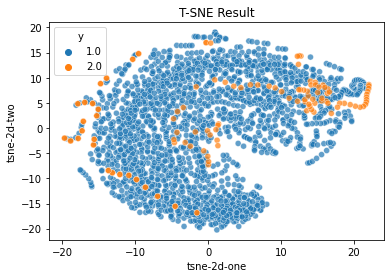

/tmp/ipykernel_3039843/3313649697.py:48: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


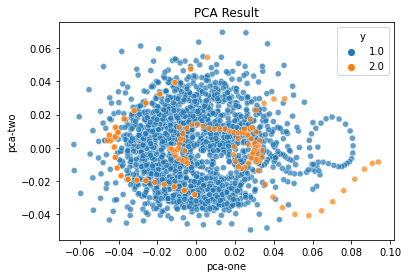

In [86]:
# import seaborn as sns 

# # normal = np.where(label_train == 0)[0]
# # rndperm = np.random.choice(normal, 2000)

# recurrent = np.where(recurrent_label == 1)[0]
# nonrecurrent = np.where(label_train == 1)[0]

# new_label = np.zeros(len(label_train))
# new_label[recurrent] = 1
# new_label[nonrecurrent] = 2


# rndperm = np.random.choice(np.where(new_label==0)[0], 2000)
# recurrent = np.where(new_label == 1)[0]
# nonrecurrent = np.where(new_label == 2)[0]

# out_center_all = 


# ## tSNE
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, perplexity=100)
# tsne_all = tsne.fit_transform(out_train[np.concatenate([recurrent, nonrecurrent])])

# tsne_df = pd.DataFrame(tsne_all, columns=['tsne-2d-one', 'tsne-2d-two'])
# tsne_df['y'] = new_label[np.concatenate([recurrent, nonrecurrent])]

# sns.scatterplot(
#     x="tsne-2d-one", y="tsne-2d-two",
#     hue="y",
#     palette=sns.color_palette("tab10", 10),
#     data=tsne_df,
#     legend="full",
#     alpha=0.7
# )

# plt.title('T-SNE Result')
# plt.show()

# ## PCA
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2, svd_solver='randomized')
# pca_all = pca.fit_transform(out_train[np.concatenate([recurrent, nonrecurrent])])

# pca_df = pd.DataFrame(pca_all, columns=['pca-one', 'pca-two'])
# pca_df['y'] = new_label[np.concatenate([recurrent, nonrecurrent])]

# sns.scatterplot(
#     x="pca-one", y="pca-two",
#     hue="y",
#     palette=sns.color_palette("tab10", 10),
#     data=pca_df,
#     legend="full",
#     alpha=0.7
# )

# plt.title('PCA Result')
# plt.show()


Text(0, 0.5, 'Distance')

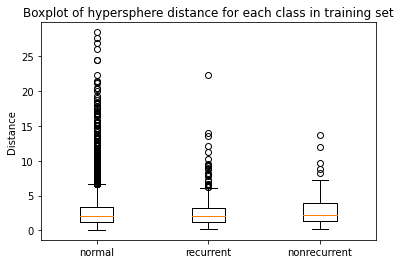

In [75]:
plt.boxplot([dist_train[np.where(new_label==0)[0]], dist_train[recurrent], dist_train[nonrecurrent]])
# plt.ylim(0, 1)
plt.xticks([1, 2, 3],['normal', 'recurrent', 'nonrecurrent'])
plt.title('Boxplot of hypersphere distance for each class in training set')
plt.ylabel('Distance')

/tmp/ipykernel_2923519/3855114425.py:2: UserWarning: The palette list has more values (8) than needed (3), which may not be intended.
  sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))


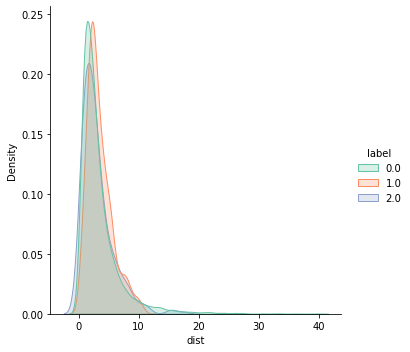

In [76]:
dist_df = pd.DataFrame([dist_all, new_label], index=['dist', 'label']).T
sns.displot(data=dist_df, x='dist', hue='label', kind='kde', fill=True, common_norm=False, common_grid=False, palette=sns.color_palette("Set2"))

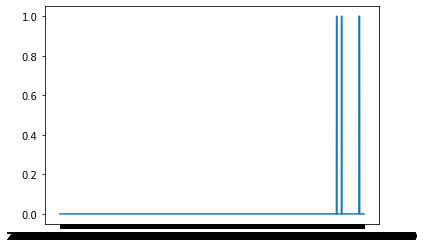

In [118]:
plt.plot(train_label)

## 1902 + 5301

In [36]:
out_sumpool_5301 = pd.read_csv('result/OCGNN_sumpool_acc5301.csv', index_col=0)
out_sumpool_1902 = pd.read_csv('result/OCGNN_sumpool_acc1902.csv', index_col=0)

In [37]:
out_sumpool_5301['pooling'] = 'sum'
out_sumpool_1902['pooling'] = 'sum'

In [41]:
out_sumpool = out_sumpool_5301.copy()
out_sumpool.iloc[:, 4:-1] = (out_sumpool_5301.iloc[:, 4:-1] + out_sumpool_1902.iloc[:, 4:-1])/2
out_sumpool

,model,normalize,nu,adjust,acc,AUC,far,precision,recall,F1_score,AP,pooling
0,GCN_gc,standard,0.05,False,0.937037,0.498027,0.987178,0.012822,0.046822,0.493745,0.013495,sum
1,GCN_gc,standard,0.05,True,0.943852,0.749310,0.867412,0.132588,0.549389,0.591962,0.078745,sum
2,GCN_traffic,standard,0.05,False,0.949896,0.490901,0.993196,0.006804,0.019129,0.492162,0.013424,sum
3,GCN_traffic,standard,0.05,True,0.952946,0.612892,0.919920,0.080080,0.263111,0.549208,0.042544,sum
4,GraphSAGE_gc,standard,0.05,False,0.953603,0.491720,0.992717,0.007283,0.017001,0.493152,0.013426,sum
5,GraphSAGE_gc,standard,0.05,True,0.956615,0.602502,0.906423,0.093577,0.238565,0.555500,0.032447,sum
6,GCN_gc,standard,0.10,False,0.845304,0.479142,0.990473,0.009527,0.102704,0.466461,0.013146,sum
7,GCN_gc,standard,0.10,True,0.853723,0.787214,0.930209,0.069791,0.718849,0.523047,0.054706,sum
8,GCN_traffic,standard,0.10,False,0.903808,0.491957,0.989213,0.010787,0.068628,0.484028,0.013399,sum
9,GCN_traffic,standard,0.10,True,0.912728,0.826038,0.894636,0.105364,0.736790,0.569068,0.082211,sum
